# Good Film // Bad Film
## Film Plot Synopses and etc. as Predictors of Critical Reception

This notebook builds a classifier which predicts whether or not a film will be "good" or "bad" based on the plot synopsis, the popularity of the leading actors, and other variables such as genre. "Good" films are those which perform better than the mean of all of the IMdB critic's rating scores in the dataset, while "bad" films score lower than that mean.

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', color_codes=True)

import nltk
from nltk import FreqDist, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import enchant
english_d = enchant.Dict("en_US")
import re
import gensim
from gensim import corpora, models, similarities
import pickle

import pyLDAvis
import pyLDAvis.gensim

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols

import xgboost as xgb
from xgboost import XGBClassifier
from patsy import dmatrices

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-eKSCkW5B/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-eKSCkW5B/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-eKSCkW5B/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-eKSCkW5B/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use

## Get the data

In [2]:
imdb = pd.read_csv('imdb_5000_movies.csv') # Just a big Kaggle dataset full of movies.

One really nice thing about this dataset is that it provides the unique IMdB movie ID's, which we can pass to another API in order to supplement our data with more features. A key to the OMdB API cost a minimum of one dollar. Here we parse out those IMdB ID's:

In [3]:
imdb.shape

(5043, 28)

In [4]:
imdb_ids = [imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0] for i in range(len(imdb))]

Here we make the API calls, and persist our data to little .txt files:

In [5]:
# for id in imdb_ids:

#     request = requests.get(f'http://www.omdbapi.com/?i={id}&plot=full&apikey={API_KEY}').json()
#     text = str(request)  
    
#     f = open(f'movie_{id}', 'w+')
#     f.write(text)
#     f.close()

This is what we want our eventual pandas dataFrame to look like:

In [6]:
df = pd.DataFrame(columns=['Title', 'Year', 'ID', 'Plot', 'Genre', 'Production', 
                           'Director', 'Actor_1_name', 'Actor_1_fb_likes', 'Actor_2_name', 
                           'Actor_2_fb_likes', 'Actor_3_name', 'Actor_3_fb_likes', 'Budget', 
                           'Rated', 'Language', 'imdbRating'])

This is where we frankenstein together the kaggle dataset with what we got from OMdB:

In [7]:
for i in range(len(imdb_ids)):
    id = imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0]
    x_file = open(os.path.join('Movies', f"movie_{id}"), "r") # Open up each movie's text file
    movie_text = x_file.readlines()[0]
    dict = eval(movie_text) # Coerce string to dictionary
    dict['Plot'] = dict['Plot'].replace("\'", "'") # Cleanup
    df = df.append({'Title': dict['Title'], 'Year': dict['Year'], 'ID': id, 
                    'Plot': dict['Plot'], 'Genre': dict['Genre'], 
                    'imdbRating': dict['imdbRating'], 
                    'Director': imdb.iloc[i,:].loc['director_name'], 
                    'Actor_1_name':imdb.iloc[i,:].loc['actor_1_name'], 
                    'Actor_1_fb_likes':imdb.iloc[i,:].loc['actor_1_facebook_likes'], 
                    'Actor_2_name':imdb.iloc[i,:].loc['actor_2_name'], 
                    'Actor_2_fb_likes':imdb.iloc[i,:].loc['actor_2_facebook_likes'], 
                    'Actor_3_name':imdb.iloc[i,:].loc['actor_3_name'], 
                    'Actor_3_fb_likes':imdb.iloc[i,:].loc['actor_3_facebook_likes'], 
                    'Budget':imdb.iloc[i,:].loc['budget'], 'Language':dict['Language'], 
                    'Rated':dict['Rated']}, ignore_index=True) # Add to dataframe

Here's our beautiful new dataFrame:

In [8]:
df.iloc[:3,:]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,Actor_2_fb_likes,Actor_3_name,Actor_3_fb_likes,Budget,Rated,Language,imdbRating
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,237000000.0,PG-13,"English, Spanish",7.8
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,300000000.0,PG-13,English,7.1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,393.0,Stephanie Sigman,161.0,245000000.0,PG-13,"English, Spanish, Italian, German, French",6.8


## Munging and EDA

We drop datapoints with null 'imdbRating' values, since that is our independent / target variable. We also convert these into binary; we are only concerned with whether or not a film's 'imbdRating' is above the mean (1) or below the mean (0). This binary value is saved into a new column called 'binary_target'.

Null values in the 'actor facebook likes' column were imputed from the column mean.

In [9]:
df = df[~((df['Plot'] == 'N/A')|(df['imdbRating'] == 'N/A'))] # Drops movies with null plots
df.imdbRating = df.imdbRating.astype(float)
df['binary_target'] = df['imdbRating'] >= df['imdbRating'].mean()   #binary target column. True = above mean ; False = below mean
df['binary_target'] = df['binary_target'].astype(int)
df['Actor_1_fb_likes'].fillna((df['Actor_1_fb_likes'].mean()), inplace=True)
df['Actor_2_fb_likes'].fillna((df['Actor_2_fb_likes'].mean()), inplace=True)
df['Actor_3_fb_likes'].fillna((df['Actor_3_fb_likes'].mean()), inplace=True)

In [10]:
df = df.reset_index()
df = df.drop(['index'], axis=1)
df[:3]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,Actor_2_fb_likes,Actor_3_name,Actor_3_fb_likes,Budget,Rated,Language,imdbRating,binary_target
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,237000000.0,PG-13,"English, Spanish",7.8,1
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,300000000.0,PG-13,English,7.1,1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,393.0,Stephanie Sigman,161.0,245000000.0,PG-13,"English, Spanish, Italian, German, French",6.8,1


### One-hot encoding Genres

In [11]:
final_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western']    

#create a list of lists, where each element is a list of a movie's classified genres
li = []
[li.append(df.iloc[i]['Genre'].split(', ')) for i in range(len(df))]

#adding columns to df for each genre, 1 represents the movie is classified under that genre, 0 is that it is not
for genre in final_genres:
    list = []
    [list.append(1) if genre in movie
    else list.append(0) for movie in li]
    df[genre] = list

### Creating a fresh DataFrame with everything but Plot Text Features

In [12]:
main_df = pd.DataFrame()

#join the features we want to narrow in on with our target variable
genres = df.iloc[:,-21:]
main_df['Year'] = [int(year.split('–')[0]) for year in df['Year'].values]
main_df = main_df.join(genres)

main_df[:3]

,Year,binary_target,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Musical,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western
0,2009,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
main_df.columns

Index(['Year', 'binary_target', 'Action', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

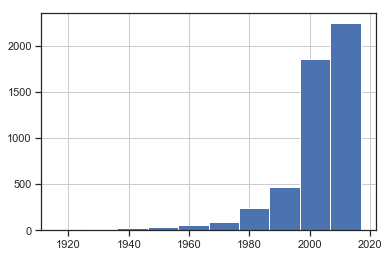

In [14]:
main_df.Year.hist()

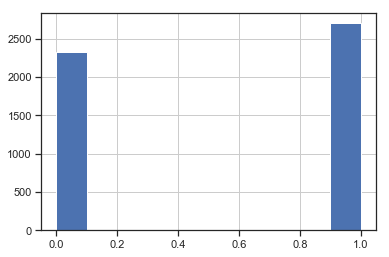

In [15]:
main_df.binary_target.hist()

### Log Transforming "Actor Facebook Likes"

'Actor_1_fb_likes' had some striking outliers and needed a log transform:

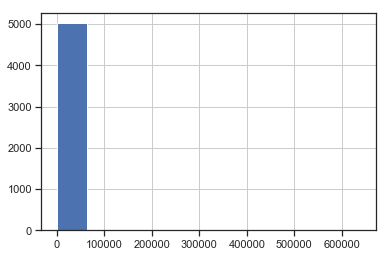

In [16]:
df.Actor_1_fb_likes.hist() # Check out those outliers. Can't even see them...

In [17]:
def log_transform_col(feature, dataframe):
    logged = pd.Series(np.log(dataframe[feature].values+1), name=feature+'_logged')
    return logged

actor_features = ['Actor_1_fb_likes', 'Actor_2_fb_likes','Actor_3_fb_likes']

actor_likes = [log_transform_col(actor_features[i], df) for i in range(len(actor_features))]

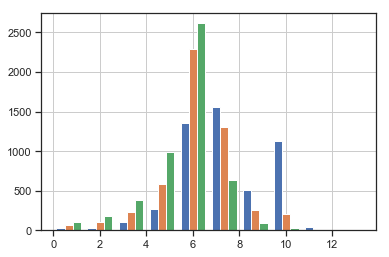

In [18]:
pd.Series(actor_likes).hist() # Much better

Looks way more gaussian after a log transform. We add these logged features to our dataframe:

In [19]:
main_df = main_df.join(actor_likes)
main_df[:3]

,Year,binary_target,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western,Actor_1_fb_likes_logged,Actor_2_fb_likes_logged,Actor_3_fb_likes_logged
0,2009,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.908755,6.842683,6.752270
1,2007,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10.596660,8.517393,6.908755
2,2015,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,9.305741,5.976351,5.087596


### Baseline Logistic Regression without Plot-Text Features

Now that we've cleaned up a bit, we'll start throwing our features at a statsmodels logistic regression estimator to evaluate r^2 and p-values of various features.

In [20]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.586021
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4005
Method:                           MLE   Df Model:                           23
Date:                Sun, 03 Mar 2019   Pseudo R-squ.:                  0.1514
Time:                        00:12:15   Log-Likelihood:                -2361.1
converged:                       True   LL-Null:                       -2782.2
                                        LLR p-value:                4.100e-163
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  84.7424      7.040     12.038      0.000      70.945   

0.6815476190476191

This gives us an idea of which features might be less important in the determination of what makes a movie "good". We'll drop the less pertinent features and try again:

In [21]:
s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance) + C(Sci_Fi)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.595035
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4013
Method:                           MLE   Df Model:                           15
Date:                Sun, 03 Mar 2019   Pseudo R-squ.:                  0.1387
Time:                        00:12:15   Log-Likelihood:                -2397.4
converged:                       True   LL-Null:                       -2783.4
                                        LLR p-value:                7.835e-155
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  83.9924      6.928     12.123      0.000      70.413   

0.7142857142857143

In [22]:
main_df.columns

Index(['Year', 'binary_target', 'Action', 'Animation', 'Biography', 'Comedy',
       'Documentary', 'Drama', 'Family', 'Horror', 'Mystery', 'Romance',
       'Sci_Fi', 'Thriller', 'Actor_1_fb_likes_logged',
       'Actor_2_fb_likes_logged', 'Actor_3_fb_likes_logged'],
      dtype='object')

These are the features we're sticking with for now.

### Correlation Matrices

We'd be remiss not to check for overly correlated features:

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-eKSCkW5B/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-eKSCkW5B/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-eKSCkW5B/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-eKSCkW5B/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserW

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-eKSCkW5B/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-eKSCkW5B/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])


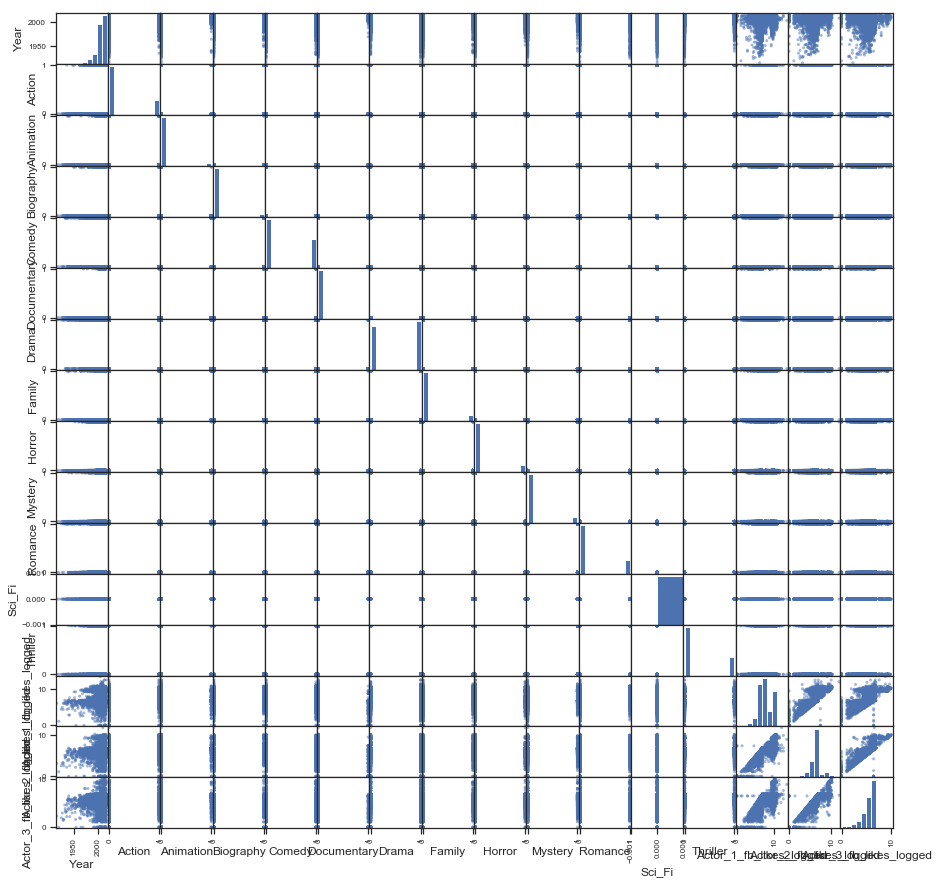

In [23]:
# Creating a multi-scatter plot
main_corr= main_df.drop(['binary_target'], axis=1).iloc[:,:]
pd.plotting.scatter_matrix(main_corr, figsize=[15,15]);

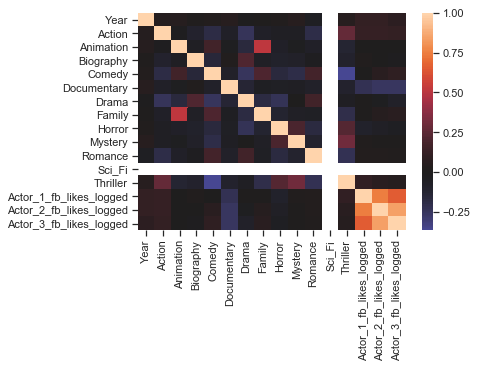

In [24]:
sns.heatmap(main_corr.corr(), center=0);

It's fairly intuitive that the social media popularity of the leading actors would be positively correlated, but we'll leave it in in case there are deviations from that norm. It's interesting to note that films in the "animation" genre are so commonly also in the "family" genre. Makes sense too.

## Using NLP to get features from the Plot Synopses

#### Setting up Lemmatization / Normalization Functions:

In [25]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize(plot_list):
    lemmatized_plots = []
    
    for plot in plot_list:
        tokenized_lower = word_tokenize(plot.lower()) # Make plot summary lowercase and lemmatize        
        tokenized_lower =[word for word in tokenized_lower if english_d.check(word)] # Make sure it's an english word
        dirty_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_lower] # Lemmatize
        dirty_lemma_string = ' '.join(dirty_lemma)
        
        # Filter out words that don't match this regex pattern:
        reg = re.compile((r"([a-zA-Z]+(?:'[a-z]+)?)"))
        lemmatized_regex = [word_lem for word_lem in dirty_lemma if word_lem in reg.findall(dirty_lemma_string)]
        
        # Remove stop words
        lemmatized = [word_lem for word_lem in lemmatized_regex if not word_lem in stop_words]
        lemmatized_string = ' '.join(lemmatized)
        lemmatized_plots.append(lemmatized_string)
        
    return lemmatized_plots

In [26]:
def get_wordnet_pos(word):
    """Map POS tag to the first character that lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

### Run the Lemmatizer

In [30]:
all_plots = [plot for plot in df.loc[:,'Plot'].values] # Get all movie plots.
plots = lemmatize(all_plots) # Lemmatize.

### Vectorizing Plots

In [31]:
# Term frequency = Number of times a word appears in a document / number of words in document
# Inverse document frequency = log base e(number of documents / number of documents with word in it)
# tf:idf = tf * idf

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(plots)
print(response.shape)

tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

(5037, 13807)


Now we have all plots lemmatized as "plots" and vectorized / weighted as "tfidf_df".

### Incorporating some LDA; Clustering Documents by Topic

Gensim clusters words that appear together frequently. The clusters can be interpreted as general topics, and each movie gets weights indicating the degree to which it belongs to each topic. These weights are then re-incorporated as features in our dataset.

In [32]:
all_words = [plot.split(' ') for plot in plots] # Just formatting our corpus how Gensim wants it

In [33]:
dictionary = corpora.Dictionary(all_words)
corpus = [dictionary.doc2bow(text) for text in all_words]
pickle.dump(corpus, open('pickles/corpus.pkl', 'wb'))
dictionary.save('pickles/dictionary.gensim')

FileNotFoundError: [Errno 2] No such file or directory: 'pickles/corpus.pkl'

In [ ]:
NUM_TOPICS = 200 # This value was arbitrarily chosen.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10) # Also arb
ldamodel.save('pickles/model5.gensim')

In [ ]:
topics = ldamodel.print_topics(num_words=4)
topics # These are examples of some of the clusters created by Gensim.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

In [34]:
tm = pd.DataFrame()
for i in range(len(corpus)):
    new_row = np.zeros(NUM_TOPICS)
    for toop in ldamodel.get_document_topics(corpus[i]): # These two lines are where you do what you need to do
        new_row[toop[0]] = toop[1]                       # to flip zeroes to ones if the genre appears
    tm = tm.append(pd.Series(new_row), ignore_index=1)

NameError: name 'NUM_TOPICS' is not defined

In [ ]:
tm.head() # This is a DataFrame with the weights from the GenSim clustering.

## Joining Topic-Modeled Synopses with Standard Features

In [ ]:
df = main_df.join(tm)
len(df.columns)

## Model Building

In [ ]:
X = df.drop(['binary_target'], axis=1)
y = df.binary_target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

train_test_split on X_scaled:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =  0.2)

### Baselining:

In [ ]:
dc = DummyClassifier().fit(X_train, y_train)

In [ ]:
accuracy_score(y_test,dc.predict(X_test))

Our baseline / dummy accuracy is 47%, roughly.

Dimensionality Reduction with SVD - For the PlotText Data:

In [ ]:
svd = TruncatedSVD(n_components=50, n_iter=3, random_state=42)
X_train_pca = pd.DataFrame(svd.fit_transform(X_train))
print(svd.explained_variance_ratio_.sum())

Next we'll try a simple Gaussian Naive Bayes Model:

In [ ]:
clf = GaussianNB()
clf.fit(X_train_pca, y_train)
y_preds = clf.predict(pd.DataFrame(svd.transform(X_test)))
print(metrics.classification_report(y_test, y_preds))
test_accuracy = accuracy_score(y_test,y_preds)
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

__________

Now we'll go nuts and try an XGBClassifier model. A boosted model seems to work better without PCA, so we'll drop it for this part.

In [ ]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)#pd.DataFrame(svd.transform(X_test)))

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

In [ ]:
y_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr, tpr)))

In [ ]:
def draw_roc_curve(fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
draw_roc_curve(fpr,tpr)

Looks like we're off to an okay start!

## Grid Searching for better parameters

In [ ]:
# svd_components = [100,500,1000]
# itera = [3, 5]

n_est = [50,80,100]
max_depth = [2,3,4]
learning_rates = [.08, .1, .15]

pipe = Pipeline([
#     ('reduce_dim', TruncatedSVD()),
    ('classify', XGBClassifier())
])

param_grid = [
    {
#         'reduce_dim__n_components': svd_components,
#         'reduce_dim__n_iter': itera,
        'classify__n_estimators': n_est,
        'classify__max_depth': max_depth,
        'classify__n_jobs': [-1],
        'classify__learning_rate': learning_rates
    }]

score = {'f1': 'f1', 
         'accuracy': 'accuracy'}

grid_adc = GridSearchCV(pipe, 
                        n_jobs=-1, 
                        param_grid=param_grid, 
                        scoring=score, 
                        refit='accuracy',
                        verbose=10)

grid_adc.fit(X_train, y_train)
grid_adc.best_params_

In [ ]:
# Check the gridsearch results:
y_preds = grid_adc.predict(X_test)
accuracy_score(y_test, y_preds)

In [ ]:
y_score = grid_adc.predict_proba(X_test)
fpr_gs, tpr_gs, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr_gs, tpr_gs)))

In [ ]:
plt.figure(0).clf()
plt.figure(figsize=(10,8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve XGBClassifier')
plt.plot(fpr_gs,tpr_gs,
         label='Grid Searched XGBClassifier')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.legend(loc=0)

Negligible improvement.